In [1]:
%reset
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from sklearn import preprocessing, manifold, linear_model, metrics, model_selection, ensemble
import seaborn as sdv
from sklearn.manifold import MDS

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
#For importing xgboost
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v4-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

import xgboost as xgb

In [3]:
# Defining the functions
def read_data(path):
    train = pd.read_csv(path + "train.csv") # the train dataset is now a Pandas DataFrame
    test = pd.read_csv(path + "test.csv") # the train dataset is now a Pandas DataFrame
    return train,test

def data_insights(df_train,df_test):
    # Let's have a peek of the train data
    #Firstly look at the prices
    pd.concat([df_train, df_test])['SalePrice'].plot(kind='hist', bins=20, title='Price frequency')
    # More deeper look into data
    # Processing the features
    # set features and labels (removing Id from features)
    X_train, y_train = df_train.iloc[:,1:-1], df_train['SalePrice']
    X_test = df_test.iloc[:,1:]
    return X_train,y_train,X_test,df_test
    
def data_preprocess(X_train, X_test):
    all_data = pd.concat([X_train, X_test])

    # Convert CentralAir to binary feature
    all_data['CentralAir'] = all_data['CentralAir'].apply(lambda x: 1 if x=='Y' else 0)
    
    # Convert MSSubClass to categorial feature
    all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)
    # types of features
    binary_features = ['CentralAir']
    categorial_features = all_data.select_dtypes(include=[object]).columns.values 
    numeric_features = all_data.select_dtypes(exclude=[object]).columns.values
    numeric_features = np.delete(numeric_features, np.argwhere(numeric_features=='CentralAir'))
    return numeric_features,categorial_features,binary_features,all_data
    
def handle_missing(numeric_features,categorial_features,all_data):    
    nans = all_data.isnull().sum()
    nans = nans[nans > 0]
    print(nans)
    # For following categorial columns change NaN for most frequent values
    cat_nan_freq = ['MasVnrType', 'Electrical', 'MSZoning', 'Utilities']
    for column in cat_nan_freq:
        all_data[column].fillna(all_data[column].value_counts().idxmax(), inplace=True)
    
    # For following categorial columns change NaN for new NA category
    cat_nan_new = categorial_features[np.in1d(categorial_features, cat_nan_freq, invert=True)]
    for column in cat_nan_new:
        all_data[column].fillna('NA', inplace=True)
    # Numeric features with NaN
    nans = all_data[numeric_features].isnull().sum()
    nan_to_numeric = nans[nans > 0].index.values
    print(nan_to_numeric)
    # Let's look on the distribution of numerical features with many NaNs
    all_data[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].hist(bins=80, figsize=(9,9))
    # Replace NaNs with medians (for mean they are too skewed)
    for column in nan_to_numeric:
        all_data[column].fillna(all_data[column].median(), inplace=True)
    # Check that we didn't miss anything
    nans = all_data.isnull().sum()
    print(nans[nans > 0])
    
    return all_data
    
def encode_categorical(all_data,categorial_features):
    # encode with dummy features
    all_data = pd.get_dummies(data=all_data, columns=categorial_features)
    all_data.info()
    return all_data
    
def scale_featues(all_data,numeric_features,df_train):
    scaler = preprocessing.StandardScaler()
    all_data[numeric_features] = scaler.fit_transform(all_data[numeric_features])
    all_data[numeric_features].head()
    # extract train and test parts of the data
    train = all_data[:df_train.shape[0]]
    test = all_data[df_train.shape[0]:]
    print(train.shape, test.shape)
    return train,test
    
def price_category(y_train):
    cl = pd.Series(index=y_train.index)
    cl[y_train < 100000] = 0
    cl[(y_train >= 100000) & (y_train < 150000)] = 1
    cl[(y_train >= 150000) & (y_train < 200000)] = 2
    cl[(y_train >= 200000) & (y_train < 250000)] = 3
    cl[(y_train >= 250000) & (y_train < 300000)] = 4
    cl[y_train >= 300000] = 5
    return cl
def data_visualize(y_train,train):
    price_classes = price_category(y_train)
    labels = ['<100K', '100-150K', '150-200K', '200-250K', '250-300K', '>300K']
    from sklearn.manifold import MDS
    mds = MDS(random_state=123)
    MDS_transformed = mds.fit_transform(train)
    
    plt.figure(figsize=(9, 9))
    colors = cm.rainbow(np.linspace(0, 1, 6))
    for cls, color, label in zip(range(6), colors, labels):
        plt.scatter(MDS_transformed[price_classes.values==cls, 0], 
                    MDS_transformed[price_classes.values==cls, 1], c=color, alpha=0.5, label=label)
    plt.legend()
    
def model_build(y_train,train,test,path,data_test):
    # Root mean squared logarithmic error (RMSLE) - underprediction is penalized greater than overprediction
    def rmsle_score(y_train, p):
        return -np.sqrt(np.sum((np.log(1+y_train) - np.log(1+p))**2)/y_train.shape[0])
    rmsle = metrics.make_scorer(rmsle_score)
    # Ridge regression
    param_grid = {
                  'alpha': [0.01, 0.05, 0.1, 0.5, 1, 2, 4, 6, 10, 15, 20, 25, 30, 40, 50],
                 }
    
    ridge = linear_model.Ridge()
    ridge_gs = model_selection.GridSearchCV(ridge, param_grid, cv=4, scoring='neg_mean_squared_error')
    ridge_gs.fit(train, y_train)
    
    print(ridge_gs.best_score_)
    print(ridge_gs.best_params_)
    
    plt.plot([item[0]['alpha'] for item in ridge_gs.grid_scores_], [np.sqrt(-item[1]) for item in ridge_gs.grid_scores_])
    plt.xlabel('alpha')
    plt.ylabel('RSME')
    plt.title('Ridge grid search')
    # Count also RMSLE on cross-validation
    param_grid = {
                  'alpha': [0.01, 0.1, 0.5, 1, 2, 6, 10, 15, 20, 30, 40, 50, 75, 100, 125],
                 }
    
    ridge = linear_model.Ridge()
    ridge_gs = model_selection.GridSearchCV(ridge, param_grid, cv=4, scoring=rmsle)
    ridge_gs.fit(train, y_train)
    print(ridge_gs.best_score_)
    print(ridge_gs.best_params_)
    
    plt.plot([item[0]['alpha'] for item in ridge_gs.grid_scores_], [-item[1] for item in ridge_gs.grid_scores_])
    plt.xlabel('alpha')
    plt.ylabel('RSMLE')
    plt.title('Ridge grid search')
    
    # Lasso regression
    param_grid = {
                  'alpha': [0.1, 0.5, 1, 2, 6, 10, 20, 30, 40, 50, 75, 100, 125, 150, 175, 200],
                 }
    lasso = linear_model.Lasso()
    lasso_gs = model_selection.GridSearchCV(lasso, param_grid, cv=4, scoring=rmsle)
    lasso_gs.fit(train, y_train)
    print(lasso_gs.best_score_)
    print(lasso_gs.best_params_)
    
    plt.plot([item[0]['alpha'] for item in lasso_gs.grid_scores_], [-item[1] for item in lasso_gs.grid_scores_])
    plt.xlabel('alpha')
    plt.ylabel('RSMLE')
    plt.title('Lasso grid search')
    
    # Check how many coefficients become zero
    coef = lasso_gs.best_estimator_.coef_
    not_zero_indices = np.where(coef!=0) 
    X_selected = train.iloc[:,not_zero_indices[0]]
    
    # Display most important features
    large_indices = np.where(abs(coef) >= 5000)
    plt.barh(range(len(large_indices[0])), coef[large_indices[0]])
    plt.yticks(range(len(large_indices[0])), train.columns[large_indices[0]])
    plt.title('Most imporant features')
    
    
    xgb_regressor = xgb.XGBRegressor()
    
    # Tune hyperparameters with grid search
    param_grid = {
                  'n_estimators': [100, 200, 300, 400, 500],
                  'learning_rate': [0.1], # I used more values, this value have best result
                  'max_depth': [3], # I used more values to tune it, 3 is the best
                 }
    xgb_gs = model_selection.GridSearchCV(xgb_regressor, param_grid, cv=3, scoring=rmsle)
    xgb_gs.fit(X_selected, y_train)
    print(xgb_gs.best_score_)
    print(xgb_gs.best_params_)
    grid_scores = tuple(zip(xgb_gs.cv_results_['params'], xgb_gs.cv_results_['mean_test_score']))
    
    scores = [(item[0]['n_estimators'], item[1]) for item in grid_scores if item[0]['learning_rate'] == 0.1]
    plt.plot(list(map(lambda x: x[0], scores)), list(map(lambda x: -x[1], scores)))
    plt.xlabel('# of trees')
    plt.ylabel('RSMLE')
    plt.title('XGBoost grid search, eta=0.1')
    #Learning rate = 0.1, number of trees = 400, max depth = 3 give best results.
    # Playing with weights regularizations (L1 works better with alpha = 10)
    params = {'learning_rate': 0.1, 'n_estimators': 400, 'max_depth': 3, 'reg_lambda': 0, 'reg_alpha': 10}
    xgb_regressor.set_params(**params)
    score = model_selection.cross_val_score(xgb_regressor, X_selected, y_train, cv=3, scoring=rmsle)
    score.mean()
    
    #Predict test data
    X_test_selected = test.iloc[:,not_zero_indices[0]]
    params = {'learning_rate': 0.1, 'n_estimators': 400, 'max_depth': 3, 'reg_lambda': 0, 'reg_alpha': 10}
    xgb_regressor.set_params(**params)
    xgb_regressor.fit(X_selected, y_train)
    y_test = xgb_regressor.predict(X_test_selected)
    result_df = pd.DataFrame(columns=['Id', 'SalePrice'])
    result_df.Id = data_test.Id
    result_df.SalePrice = y_test
    result_df.head()
    
    result_df.to_csv(path+'output.csv', index=False)
    
def main(path):
    #reading data
    data = read_data(path)
    data_train = data[0]
    data_test = data[1]
    #data insights
    insight_out = data_insights(data_train,data_test)
    train = insight_out[0]
    target = insight_out[1]
    test = insight_out[2]
    data_test = insight_out[3]
    #data preprocessing
    preprocess_out = data_preprocess(train,test)
    data_num_feat = preprocess_out[0]
    data_cat_feat = preprocess_out[1]
    data_bin_feat = preprocess_out[2]
    data_all = preprocess_out[3]
    #Handling missing values
    missing_out = handle_missing(data_num_feat,data_cat_feat,data_all)
    data_all = missing_out
    #Encode the categorical features
    encode_out = encode_categorical(data_all,data_cat_feat)
    data_all = encode_out
    #Feature scaling
    scale_out = scale_featues(data_all,data_num_feat,data_train)
    train = scale_out[0]
    test = scale_out[1]
    #Visualize the data
    #Dividing data into categories to visualize
    data_visualize(target,train)
    #Finally working with ridge and lasso regression to get important features and biuld a model in XGBoost
    model_build(target,train,test,path,data_test)

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64
['LotFrontage' 'MasVnrArea' 'BsmtFinSF1' 'BsmtFinSF2' 'BsmtUnfSF'
 'TotalBsmtSF' 'BsmtFullBath' 'BsmtHalfBath' 'GarageYrBlt' 'GarageCars'
 'GarageArea']
Series([], dtype: int64)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Columns: 321 entries,

C:\Program Files\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Program Files\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


-0.145078884641
{'alpha': 100}


C:\Program Files\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Program Files\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Program Files\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


-0.139703141226
{'alpha': 175}


C:\Program Files\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Program Files\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


-0.126508345123
{'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 3}


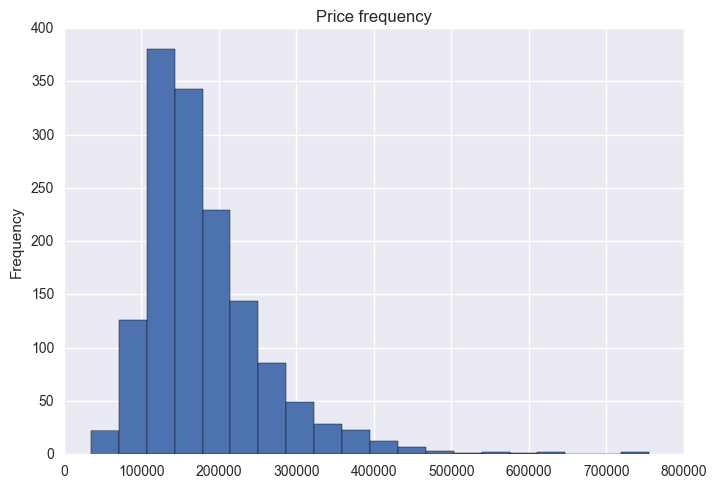

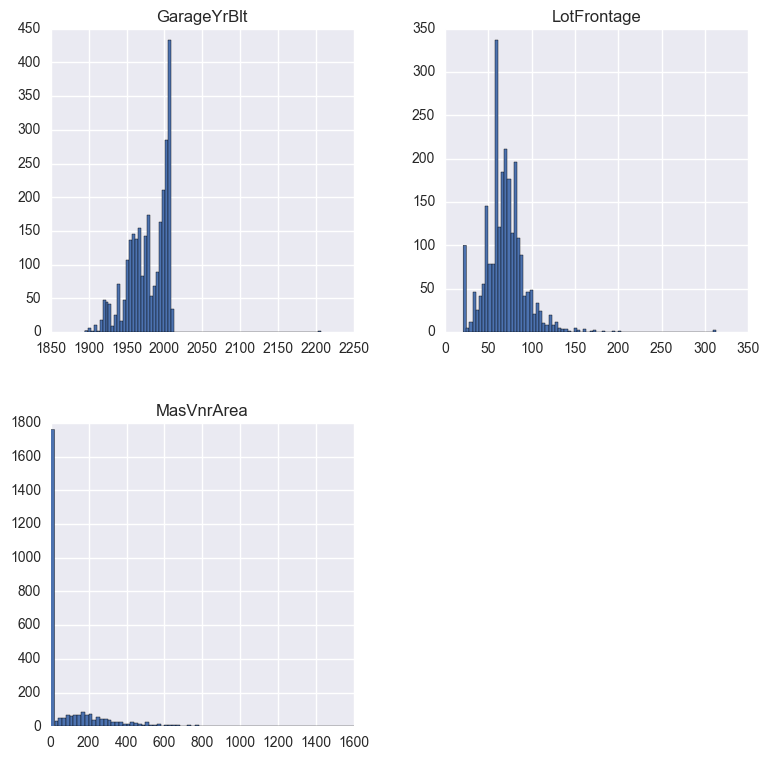

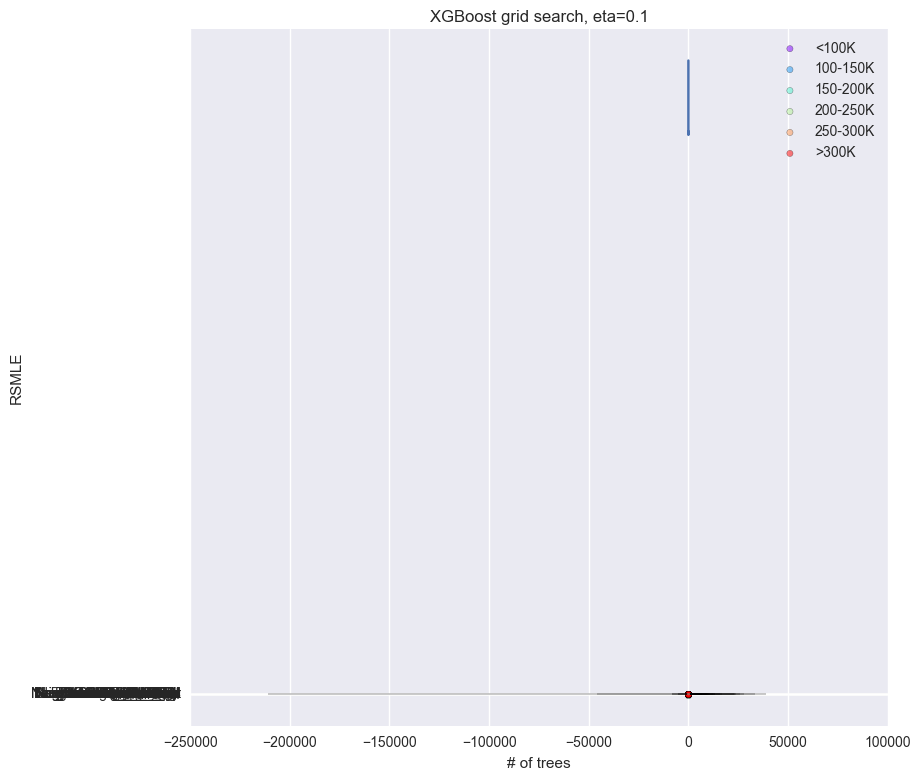

In [4]:
path = "H:\\Kaggle\\housingprice\\"
#calling main function 
main(path)